# Hello PixelCNN using Tensorflow mixtyre distrobutions

In [2]:
# Prerequisites
import sys
import numpy as np

import tensorflow as tf
from tensorflow.keras import datasets, layers, models, optimizers, callbacks

# pip install tensorflow_probability[tf]
import tensorflow_probability as tfp

from utils import display

print("Python Version: ", sys.version)

Python Version:  3.12.3 (main, Feb  4 2025, 14:48:35) [GCC 13.3.0]


### Get Data
Use FashionMNIST from TensorFlow datasets

In [3]:

(x_train, _), (_, _) = datasets.fashion_mnist.load_data()

### Preprocess Data

Scale down in size and image depth to make the training time reasonable

I0000 00:00:1749594599.966622 1094985 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9349 MB memory:  -> device: 0, name: NVIDIA TITAN V, pci bus id: 0000:04:00.0, compute capability: 7.0


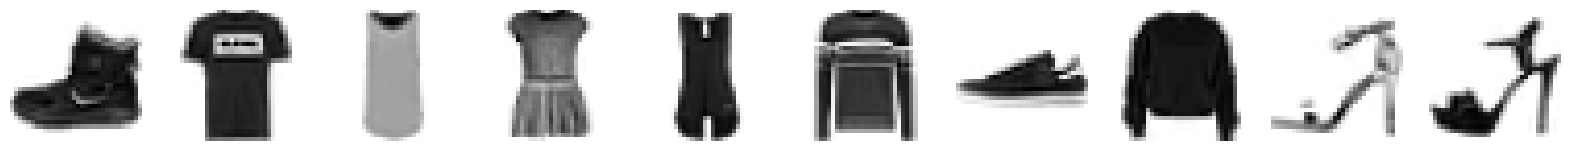

In [4]:
IMAGE_SIZE = 32

# Function to preprocess the images
def preprocess(imgs):
    imgs = np.expand_dims(imgs, -1)
    imgs = tf.image.resize(imgs, (IMAGE_SIZE, IMAGE_SIZE)).numpy()
    return imgs


# Preprocess the training data
input_data = preprocess(x_train)

# Display some sample preprocessed images
display(input_data)

### Define PixelCNN

#### Define PixelCNN itself

In [5]:
N_COMPONENTS = 5

# Define a Pixel CNN network
dist = tfp.distributions.PixelCNN(
    image_shape=(IMAGE_SIZE, IMAGE_SIZE, 1),
    num_resnet=1,
    num_hierarchies=2,
    num_filters=32,
    num_logistic_mix=N_COMPONENTS,
    dropout_p=0.3,
)

# Custom layer to compute and add negative log-likelihood loss
class LogProbLayer(layers.Layer):
    def call(self, inputs):
        log_prob = dist.log_prob(inputs)
        self.add_loss(-tf.reduce_mean(log_prob))  # Add loss internally
        return log_prob

# Define the model input
image_input = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 1))

log_prob_output = LogProbLayer()(image_input)

# Define the model
pixelcnn = models.Model(inputs=image_input, outputs=log_prob_output)


### Train the PixelCNN

In [6]:
# Compile and train the model
pixelcnn.compile(
    optimizer=optimizers.Adam(0.001),
)

In [7]:
tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")


class ImageGenerator(callbacks.Callback):
    def __init__(self, num_img):
        self.num_img = num_img

    def generate(self):
        return dist.sample(self.num_img).numpy()

    def on_epoch_end(self, epoch, logs=None):
        generated_images = self.generate()
        display(
            generated_images,
            n=self.num_img,
            save_to="./output/generated_md_img_%03d.png" % (epoch),
        )


img_generator_callback = ImageGenerator(num_img=2)

Epoch 1/10


/home/jari/MyGitHub/ML_Generative_AI_Experiments/.venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py:82: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")
I0000 00:00:1749594615.334633 1095073 service.cc:152] XLA service 0x1e4d51a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1749594615.334652 1095073 service.cc:160]   StreamExecutor device (0): NVIDIA TITAN V, Compute Capability 7.0
2025-06-10 15:30:15.421913: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1749594616.168460 1095073 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-06-10 15:30:17.125837: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.

  7/469 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 4232.7007

I0000 00:00:1749594619.820926 1095073 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


468/469 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 4294.0098

2025-06-10 15:30:29.024490: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.96 = (f32[96,32,32,32]{3,2,1,0}, u8[0]{0}) custom-call(f32[96,64,32,32]{3,2,1,0} %bitcast.16212, f32[32,64,3,3]{3,2,1,0} %bitcast.14457, f32[32]{0} %bitcast.14459), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="functional_1/log_prob_layer_1/PixelCNN_CONSTRUCTED_AT_top_level/log_prob/private__pixel_cnn_network/model/weight_norm_3/StatefulPartitionedCall/conv2d_3/Conv2D" source_file="/home/jari/MyGitHub/ML_Generative_AI_Experiments/.venv/lib/python3.12/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu

469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 4294.0220
Saved to ./output/generated_md_img_000.png


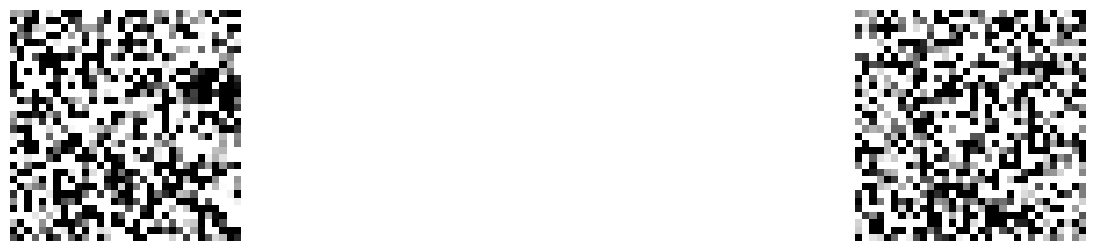

469/469 ━━━━━━━━━━━━━━━━━━━━ 75s 148ms/step - loss: 4294.0347
Epoch 2/10
467/469 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 4302.4502
Saved to ./output/generated_md_img_001.png


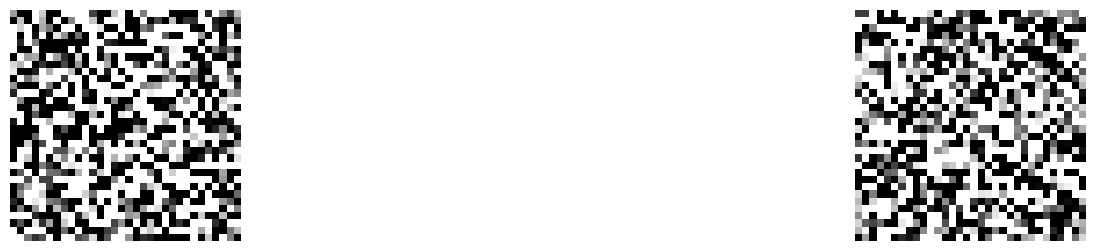

469/469 ━━━━━━━━━━━━━━━━━━━━ 63s 134ms/step - loss: 4302.4331
Epoch 3/10
468/469 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 4306.2319
Saved to ./output/generated_md_img_002.png


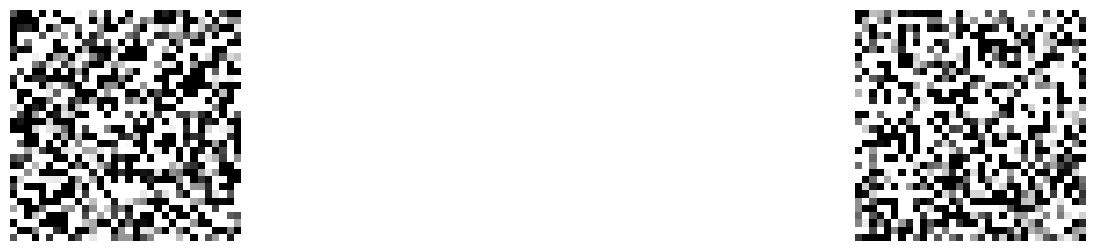

469/469 ━━━━━━━━━━━━━━━━━━━━ 62s 133ms/step - loss: 4306.2046
Epoch 4/10
467/469 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 4298.2876
Saved to ./output/generated_md_img_003.png


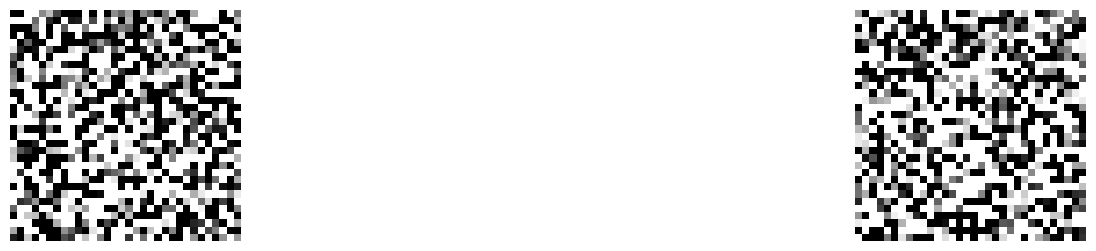

469/469 ━━━━━━━━━━━━━━━━━━━━ 62s 133ms/step - loss: 4298.2974
Epoch 5/10
467/469 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 4297.9546
Saved to ./output/generated_md_img_004.png


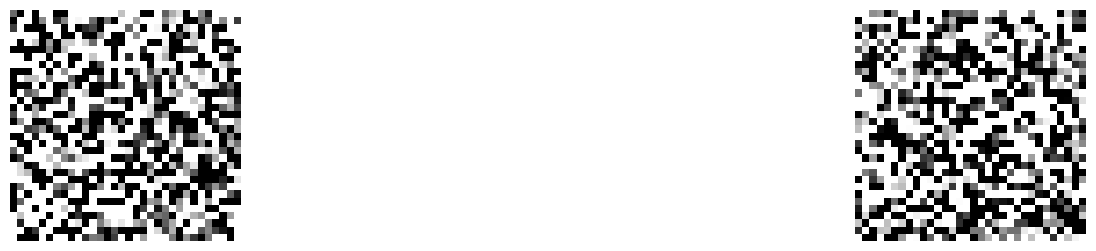

469/469 ━━━━━━━━━━━━━━━━━━━━ 62s 133ms/step - loss: 4297.9663
Epoch 6/10
466/469 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 4300.1445
Saved to ./output/generated_md_img_005.png


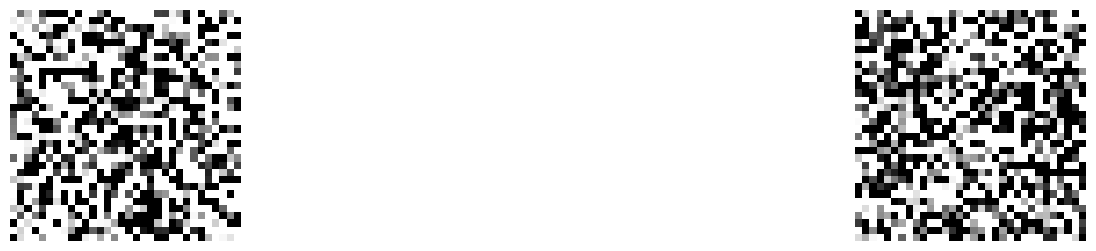

469/469 ━━━━━━━━━━━━━━━━━━━━ 62s 133ms/step - loss: 4300.1401
Epoch 7/10
467/469 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 4301.5020
Saved to ./output/generated_md_img_006.png


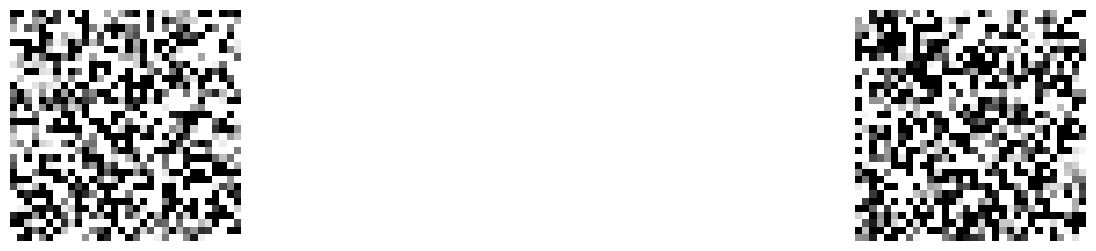

469/469 ━━━━━━━━━━━━━━━━━━━━ 62s 133ms/step - loss: 4301.4912
Epoch 8/10
468/469 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 4299.8130
Saved to ./output/generated_md_img_007.png


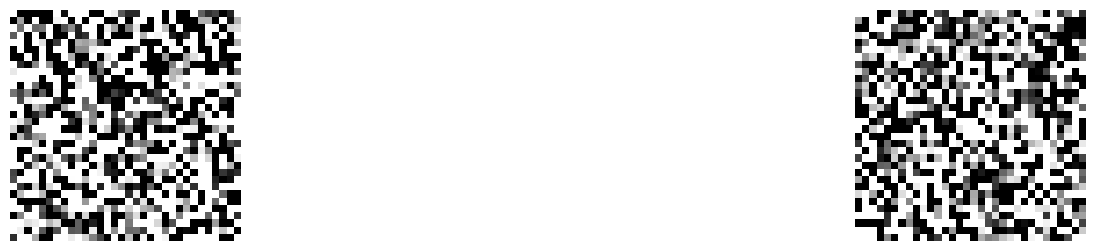

469/469 ━━━━━━━━━━━━━━━━━━━━ 62s 133ms/step - loss: 4299.8130
Epoch 9/10
467/469 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 4297.7422
Saved to ./output/generated_md_img_008.png


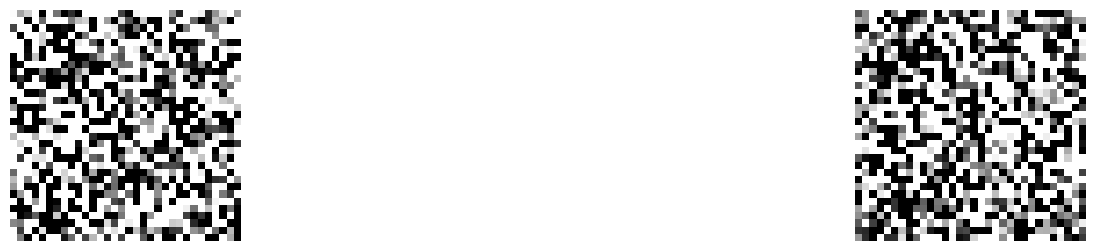

469/469 ━━━━━━━━━━━━━━━━━━━━ 62s 133ms/step - loss: 4297.7554
Epoch 10/10
467/469 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 4300.4878
Saved to ./output/generated_md_img_009.png


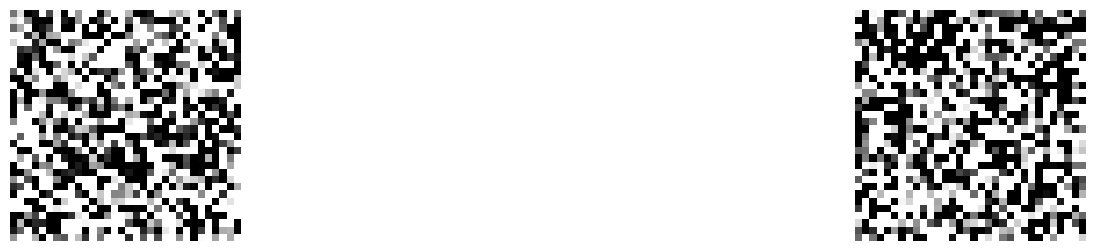

469/469 ━━━━━━━━━━━━━━━━━━━━ 62s 133ms/step - loss: 4300.4834


In [8]:
BATCH_SIZE = 128
EPOCHS = 10

# Fit the model
pixelcnn.fit(
    input_data,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    verbose=True,
    callbacks=[tensorboard_callback, img_generator_callback],
)

### Generate Images

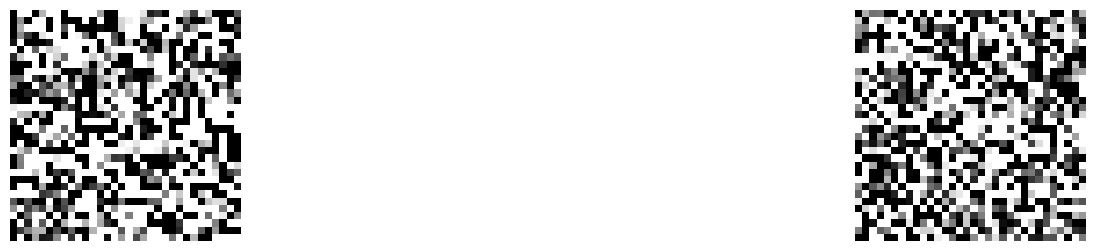

In [9]:
generated_images = img_generator_callback.generate()
display(generated_images, n=img_generator_callback.num_img)